# Zoonosis

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

## Set initial value parameters

In [2]:
beta_HH = 0.01
beta_HV = 0.01
beta_VV = 1.225
beta_VH = 0.05

S_H_0 = 1
S_V_0 = 0.9
I_H_0 = 0
I_V_0 = 0.1

mu_I_V = 0.45
mu_I_H = 0.01

gamma_H, gamma_V = 1/30, 0

mu_V, mu_H = 5/365, 0.05/365

y_0 = (S_H_0, S_V_0, I_H_0, I_V_0)

In [3]:
print(f"R_0, human-to-human: {beta_HH / gamma_H + mu_I_H + mu_H}")

R_0, human-to-human: 0.3101369863013699


In [4]:
print(f"R_0, vector: {(beta_VV)/(gamma_V + mu_V + mu_I_V)}")

R_0, vector: 2.6418020679468244


## Defining the system of ODEs as a function

In [5]:
def deriv(t, y, beta, gamma, mu, mu_2, beta_2, psi):
    S_H, S_V, I_H, I_V = y
    gamma_H, gamma_V = gamma
    beta_HH, beta_HV, beta_VV, beta_VH = beta
    mu_H, mu_V = mu

    eff_mu_V = mu_V * (1 + (mu_2 * np.sin(2 * np.pi/180 * t)))
    eff_beta_VV = beta_VV * (1 + (beta_2 * np.sin(2 * np.pi/365 * (t - psi))))

    dShdt = mu_H - (beta_HH * S_H * I_H + beta_HV * S_H * I_V) - mu_H * S_H
    dSvdt = eff_mu_V - (eff_beta_VV * S_V * I_V + beta_VH * S_V * I_H) - mu_V * S_V
    dIhdt = (beta_HH * S_H * I_H + beta_HV * S_H * I_V) - gamma_H * I_H - mu_H * I_H - mu_I_H * I_H
    dIvdt = (eff_beta_VV * S_V * I_V + beta_VH * S_V * I_H) - gamma_V * I_V - mu_V * I_V - mu_I_V * I_V

    return dShdt, dSvdt, dIhdt, dIvdt

## Solve the IVP

In [6]:
solve_ivp(fun=deriv, t_span = (0, 1000), y0=y_0, max_step=1, method="BDF", args=((beta_HH, beta_HV, beta_VV, beta_VH),
                                                                                       (gamma_H, gamma_V),
                                                                                       (mu_H, mu_V), 0.9, 0.8, 30)).y[2, -1]

0.0032159026878452357

## Plot results

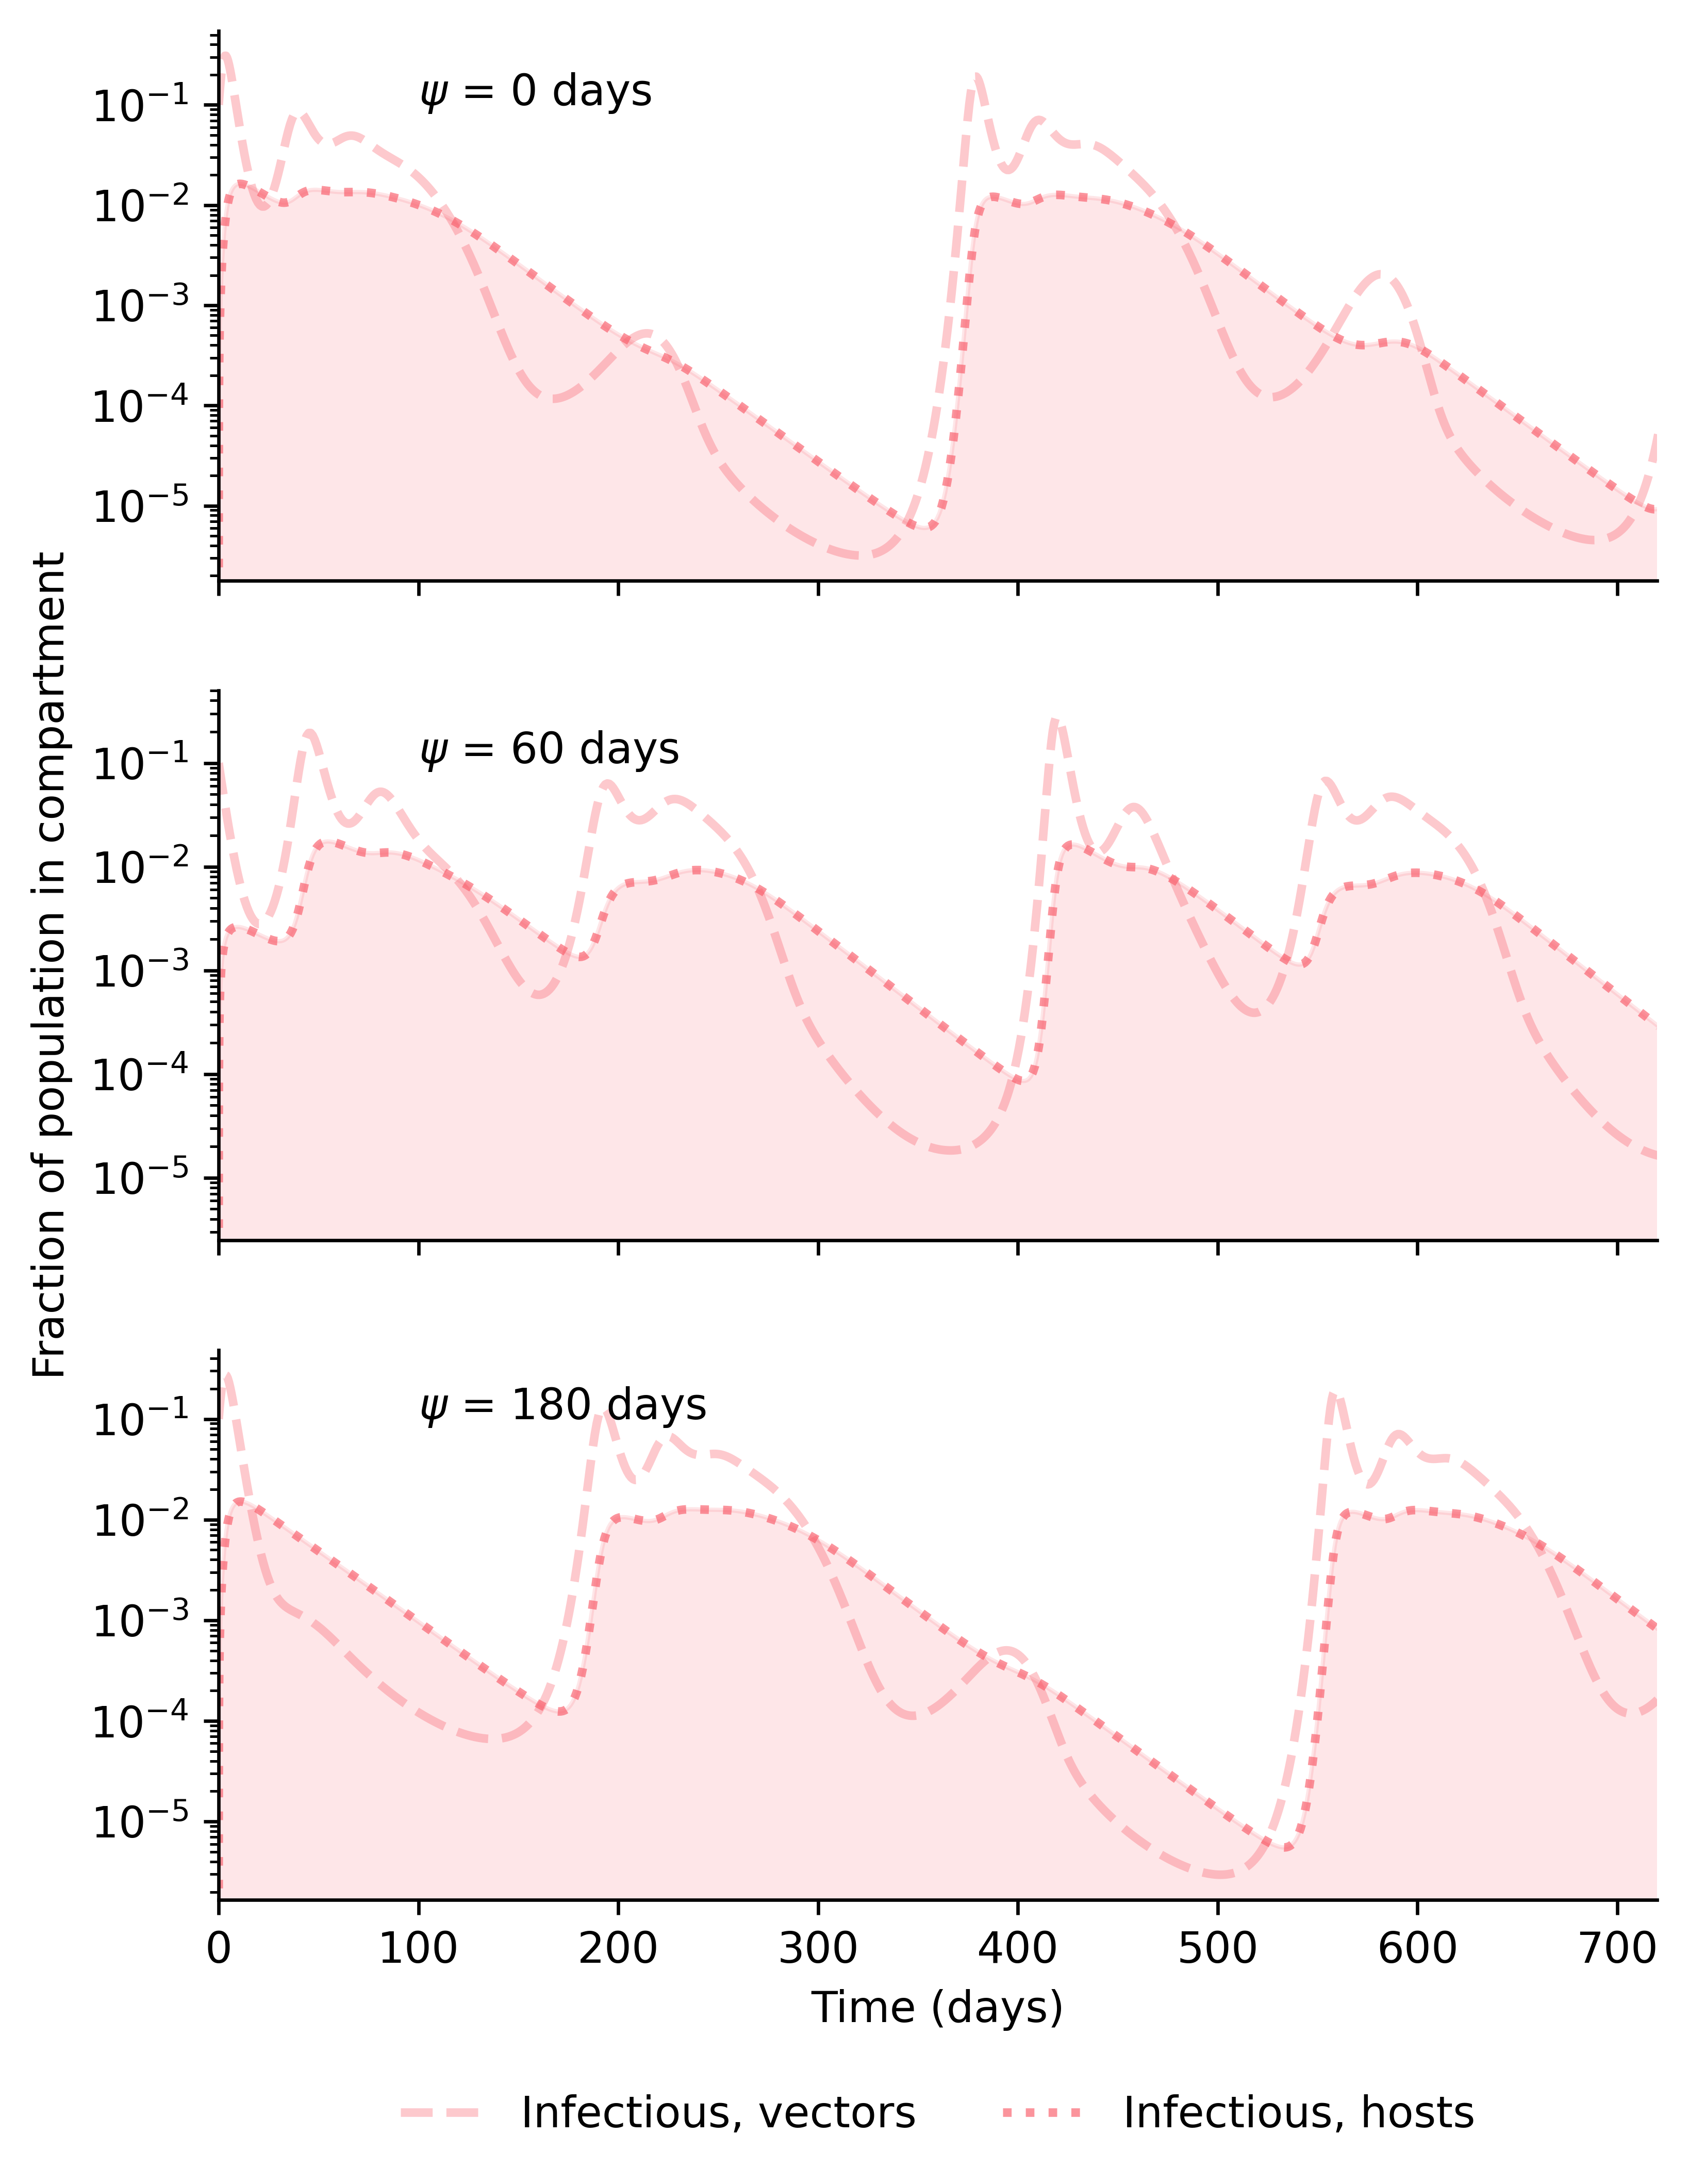

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8), dpi=600)

phases = [0, 60, 180]

for idx, val in enumerate(phases):
    res = solve_ivp(fun=deriv, t_span = (0, 1000), y0=y_0, max_step=1, method="BDF", args=((beta_HH, beta_HV, beta_VV, beta_VH),
                                                                                       (gamma_H, gamma_V),
                                                                                       (mu_H, mu_V), 0.85, 1, val))

    Sh, Sv, Ih, Iv = res.y

    ax = axs[idx]

    ax.plot(res.t, Iv, color=COLORS["I"], alpha=0.33, lw=2, label="Infectious, vectors", linestyle="dashed")
    ax.plot(res.t, Ih, color=COLORS["I"], alpha=0.66, lw=2, label="Infectious, hosts", linestyle="dotted")
    ax.fill_between(res.t, 0, Ih, color=COLORS["I"], alpha=0.15)

    if idx == 2:
        ax.set_xlabel("Time (days)")
    
    if idx == 1:
        ax.set_ylabel("Fraction of population in compartment")

    ax.text(100, 1e-1, f"$\psi$ = {val} days")

    ax.set_xlim(0, 720)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    ax.set_yscale("log")

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.5), loc="lower center", ncol=2, frameon=False)
plt.savefig("zoonosis_forced.pdf", dpi=600)
plt.show()